In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [2]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [3]:
acc_healthy = pd.read_csv('data_new_preprocessed/acc_healthy_samples.csv')
acc_15 = pd.read_csv('data_new_preprocessed/acc_15_samples.csv')
acc_35 = pd.read_csv('data_new_preprocessed/acc_35_samples.csv')

gyro_healthy = pd.read_csv('data_new_preprocessed/gyro_healthy_samples.csv')
gyro_15 = pd.read_csv('data_new_preprocessed/gyro_15_samples.csv')
gyro_35 = pd.read_csv('data_new_preprocessed/gyro_35_samples.csv')

gyro_agg_healthy = pd.read_csv('data_new_preprocessed/gyro_agg_healthy_samples.csv')
gyro_agg_15 = pd.read_csv('data_new_preprocessed/gyro_agg_15_samples.csv')
gyro_agg_35 = pd.read_csv('data_new_preprocessed/gyro_agg_35_samples.csv')

In [4]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_15_data = np.array([acc_15[col].values for col in acc_15.columns if col.startswith('Sample')])
acc_35_data = np.array([acc_35[col].values for col in acc_35.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_15_data,acc_35_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_15_data = np.array([gyro_15[col].values for col in gyro_15.columns if col.startswith('Sample')])
gyro_35_data = np.array([gyro_35[col].values for col in gyro_35.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_15_data,gyro_35_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_15_data = np.array([gyro_agg_15[col].values for col in gyro_agg_15.columns if col.startswith('Sample')])
gyro_agg_35_data = np.array([gyro_agg_35[col].values for col in gyro_agg_35.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_15_data, gyro_agg_35_data]

Prior predictive check model 1

In [12]:
prior_model_1 = CmdStanModel(stan_file='stan/prior_check.stan')

In [13]:
num_knots = 15
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)

data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples = prior_model_1.sample(data=data_ppc)

09:45:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:45:42 - cmdstanpy - INFO - CmdStan done processing.


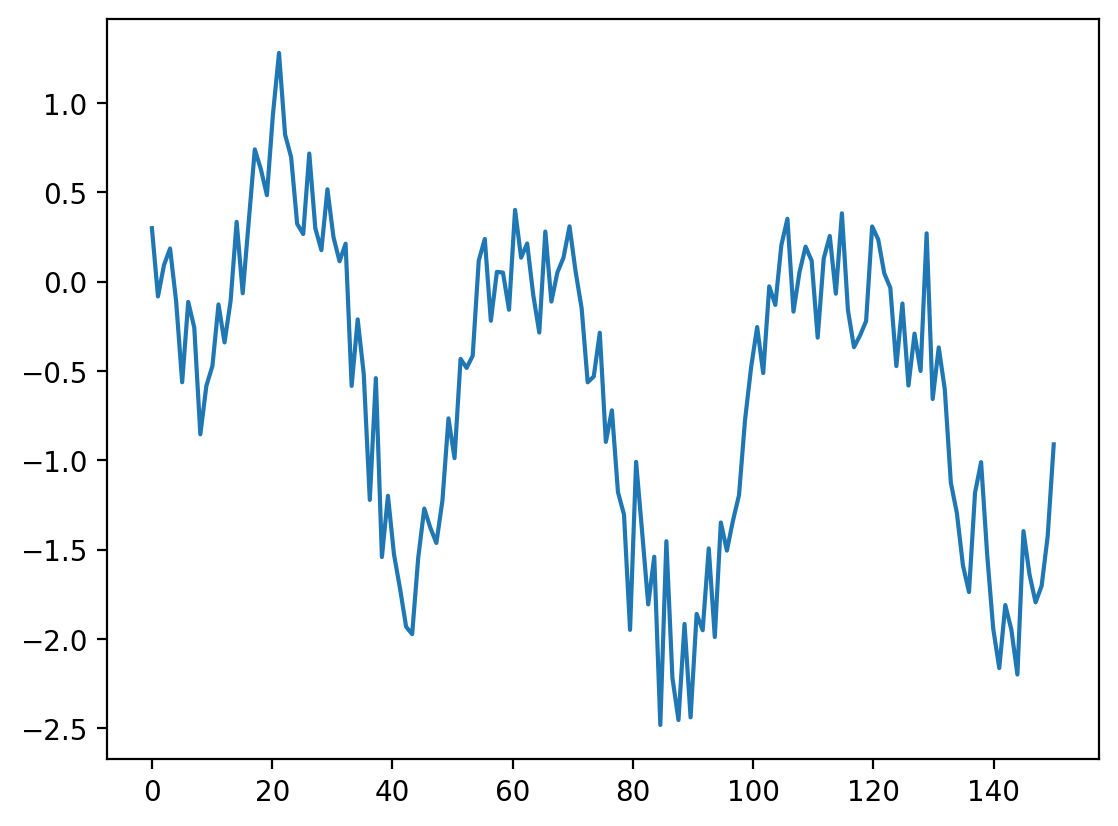

In [14]:
sample_1 = ppc_samples.stan_variable('y_pred')[1]
x = np.linspace(0,150,N)
plt.plot(x,sample_1)

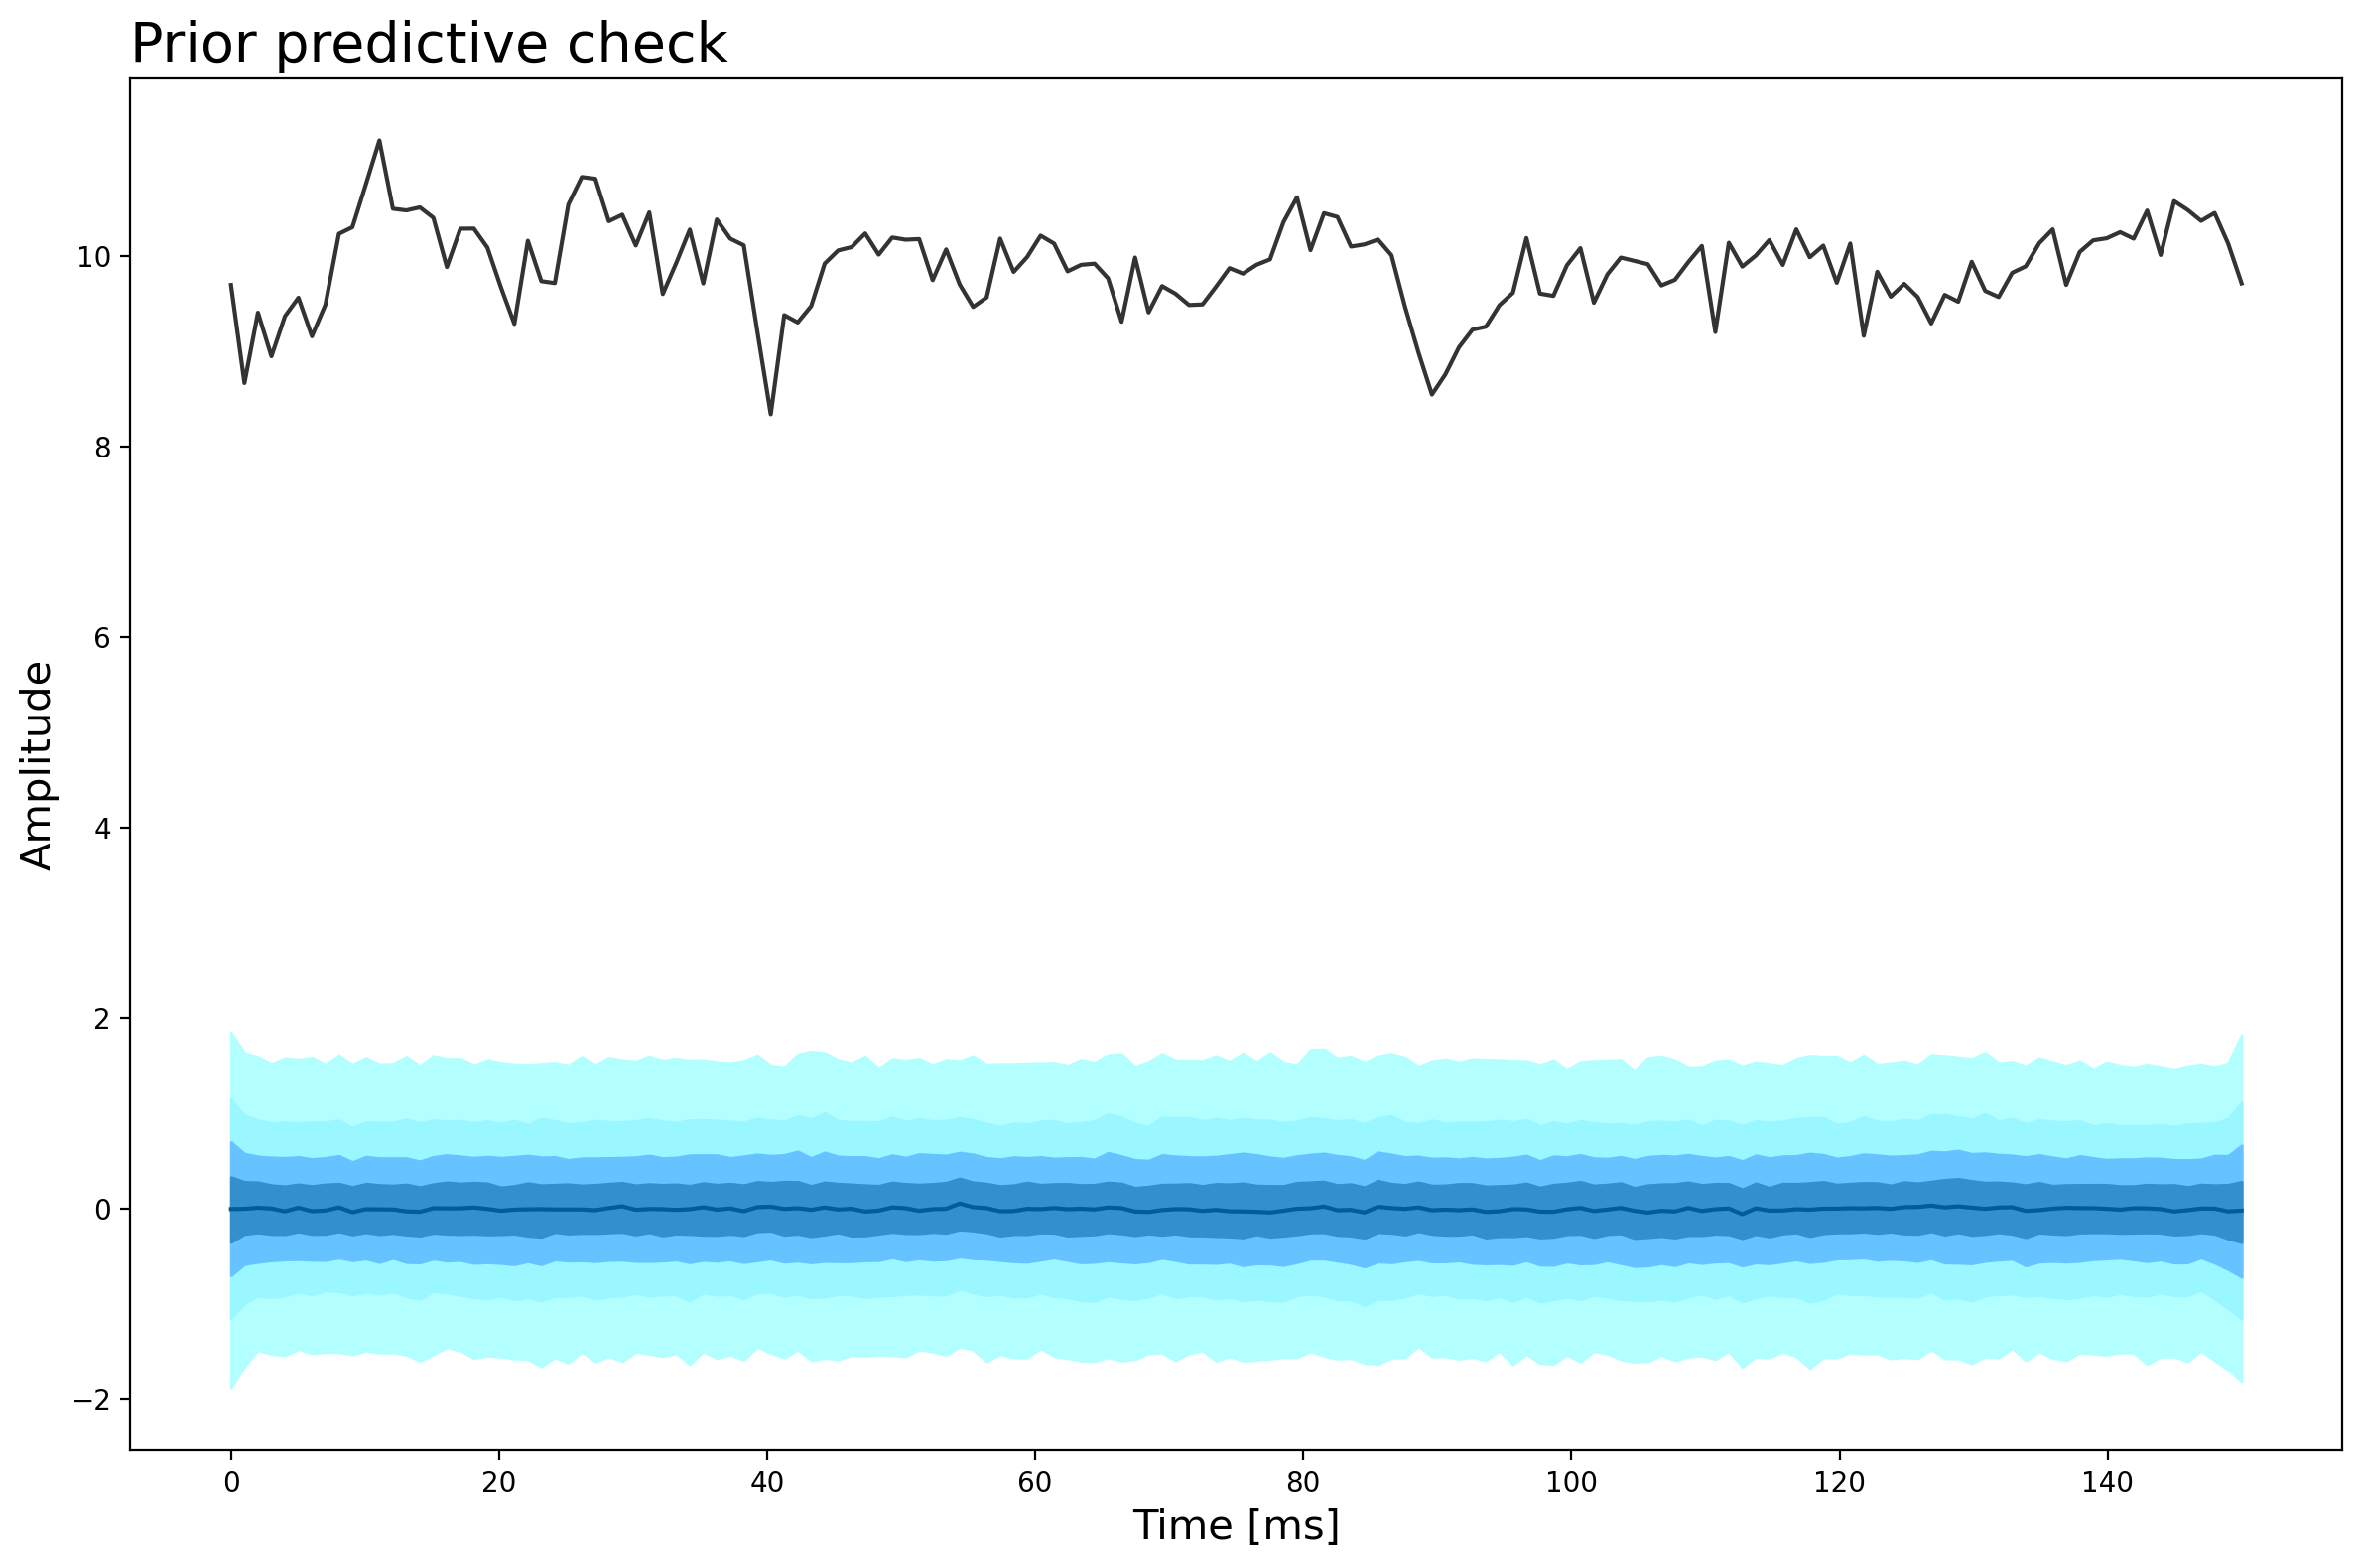

In [15]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
beta_pred= ppc_samples.stan_variable('betas')[:,:]
pred = ppc_samples.stan_variable('y_pred')
axes = ribbon_plot(x,pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Prior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[1], color = 'k',alpha=0.8)

Posterior Check model 1

As a posterior check we provide accuracy of our model, calculated as statistic of 100 independent runs and also we create generative model for each class to compare them with real signals

In [16]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 15
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior = model_posterior.sample(data=data_ppc)



09:45:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:45:44 - cmdstanpy - INFO - CmdStan done processing.


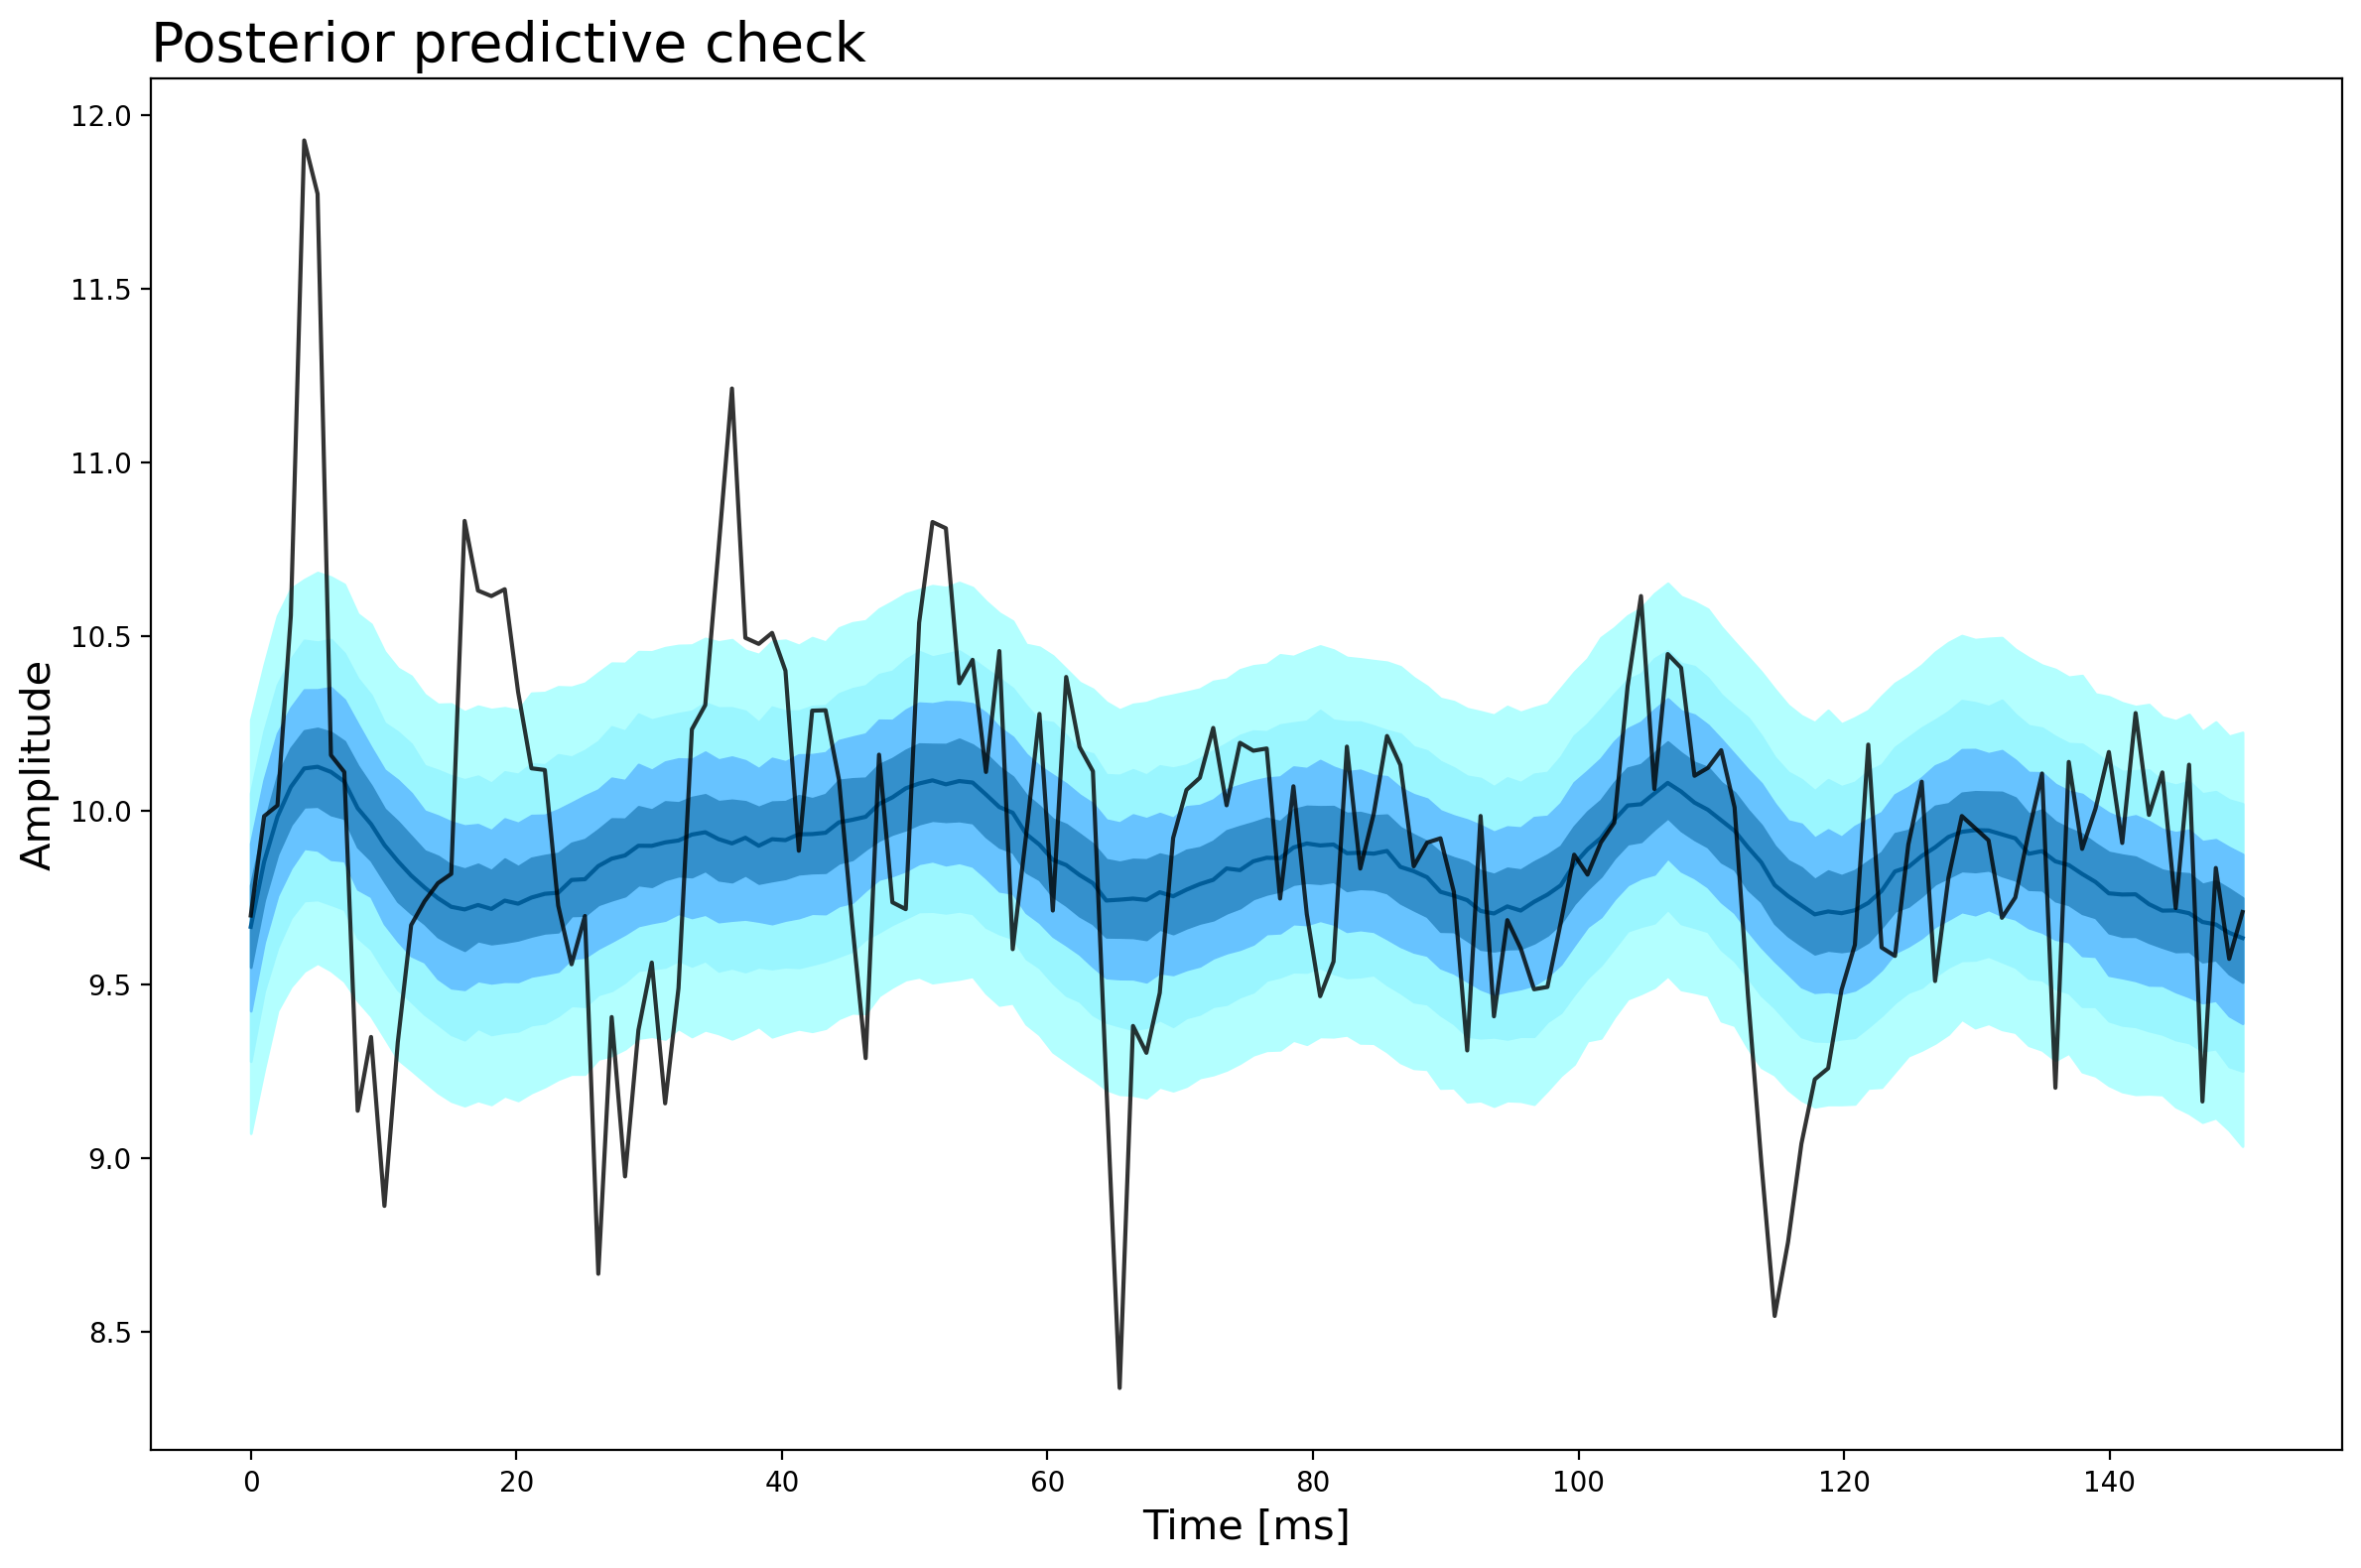

In [21]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
y_pred= samples_posterior.stan_variable('y_pred')[:,:]
axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)

In [22]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, 
                 mode = 'binary', training_samples = 5,lambda0=None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        IL1 = training_samples
        IL2 = training_samples
        IL = IL1+IL2

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])+len(data_array[2])
        data_array_damaged = np.concatenate([data_array[1], data_array[2]])
        total = num_healthy + num_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array_damaged)[sampling_order_2[:IL2]]])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array_damaged)[sampling_order_2[IL2:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

        IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        IL1 = training_samples
        IL2 = training_samples
        IL3 = training_samples
        IL = IL1+IL2+IL3

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])
        num_very_damaged = len(data_array[2])

        total = num_healthy + num_damaged + num_very_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])
        sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array[1])[sampling_order_2[:IL2]],
            np.array(data_array[2])[sampling_order_3[:IL3]],
            ])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array[1])[sampling_order_2[IL2:]],
                np.array(data_array[2])[sampling_order_3[IL3:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

        IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out, y_test_labels, IT, IL, total, B0, knot_list
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary',plot = False, seed = None):
    if not seed:
        seed = np.random.randint(0,100000)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)

    if plot:
        fig, ax = plt.subplots(2,1,figsize=(10,6),tight_layout=True)

        x = np.arange(1,len(cat1p)+1)
        ax[0].scatter(x, (cat1p["mean"].values))
        ax[0].errorbar(x, cat1p["mean"].values, np.abs([cat1p["mean"].values-cat1p["hdi_3%"].values,
                    cat1p["hdi_97%"].values-cat1p["mean"].values]), linestyle='none')


        x = np.arange(1,len(cat2p)+1)
        ax[1].scatter(x, (cat2p["mean"].values))
        ax[1].errorbar(x, cat2p["mean"].values, np.abs([cat2p["mean"].values-cat2p["hdi_3%"].values,
                    cat2p["hdi_97%"].values-cat2p["mean"].values]), linestyle='none')



        ax[0].set_title('Healthy', loc='left',fontsize = 20)
        ax[0].set_ylabel('Probability')
        ax[1].set_title('Damaged', loc='left',fontsize = 20)
        ax[1].set_ylabel('Probability')
        ax[0].set_xticks([1,len(cat1p)])
        ax[1].set_xticks([1,len(cat2p)])
        ax[0].set_ylim([-0.05,1.05])
        ax[0].set_yticks([0,1])
        ax[1].set_ylim([-0.05,1.05])
        ax[1].set_yticks([0,1])
    
    return hit_rate
        

10:27:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:27:25 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9074074074074074


0.9074074074074074

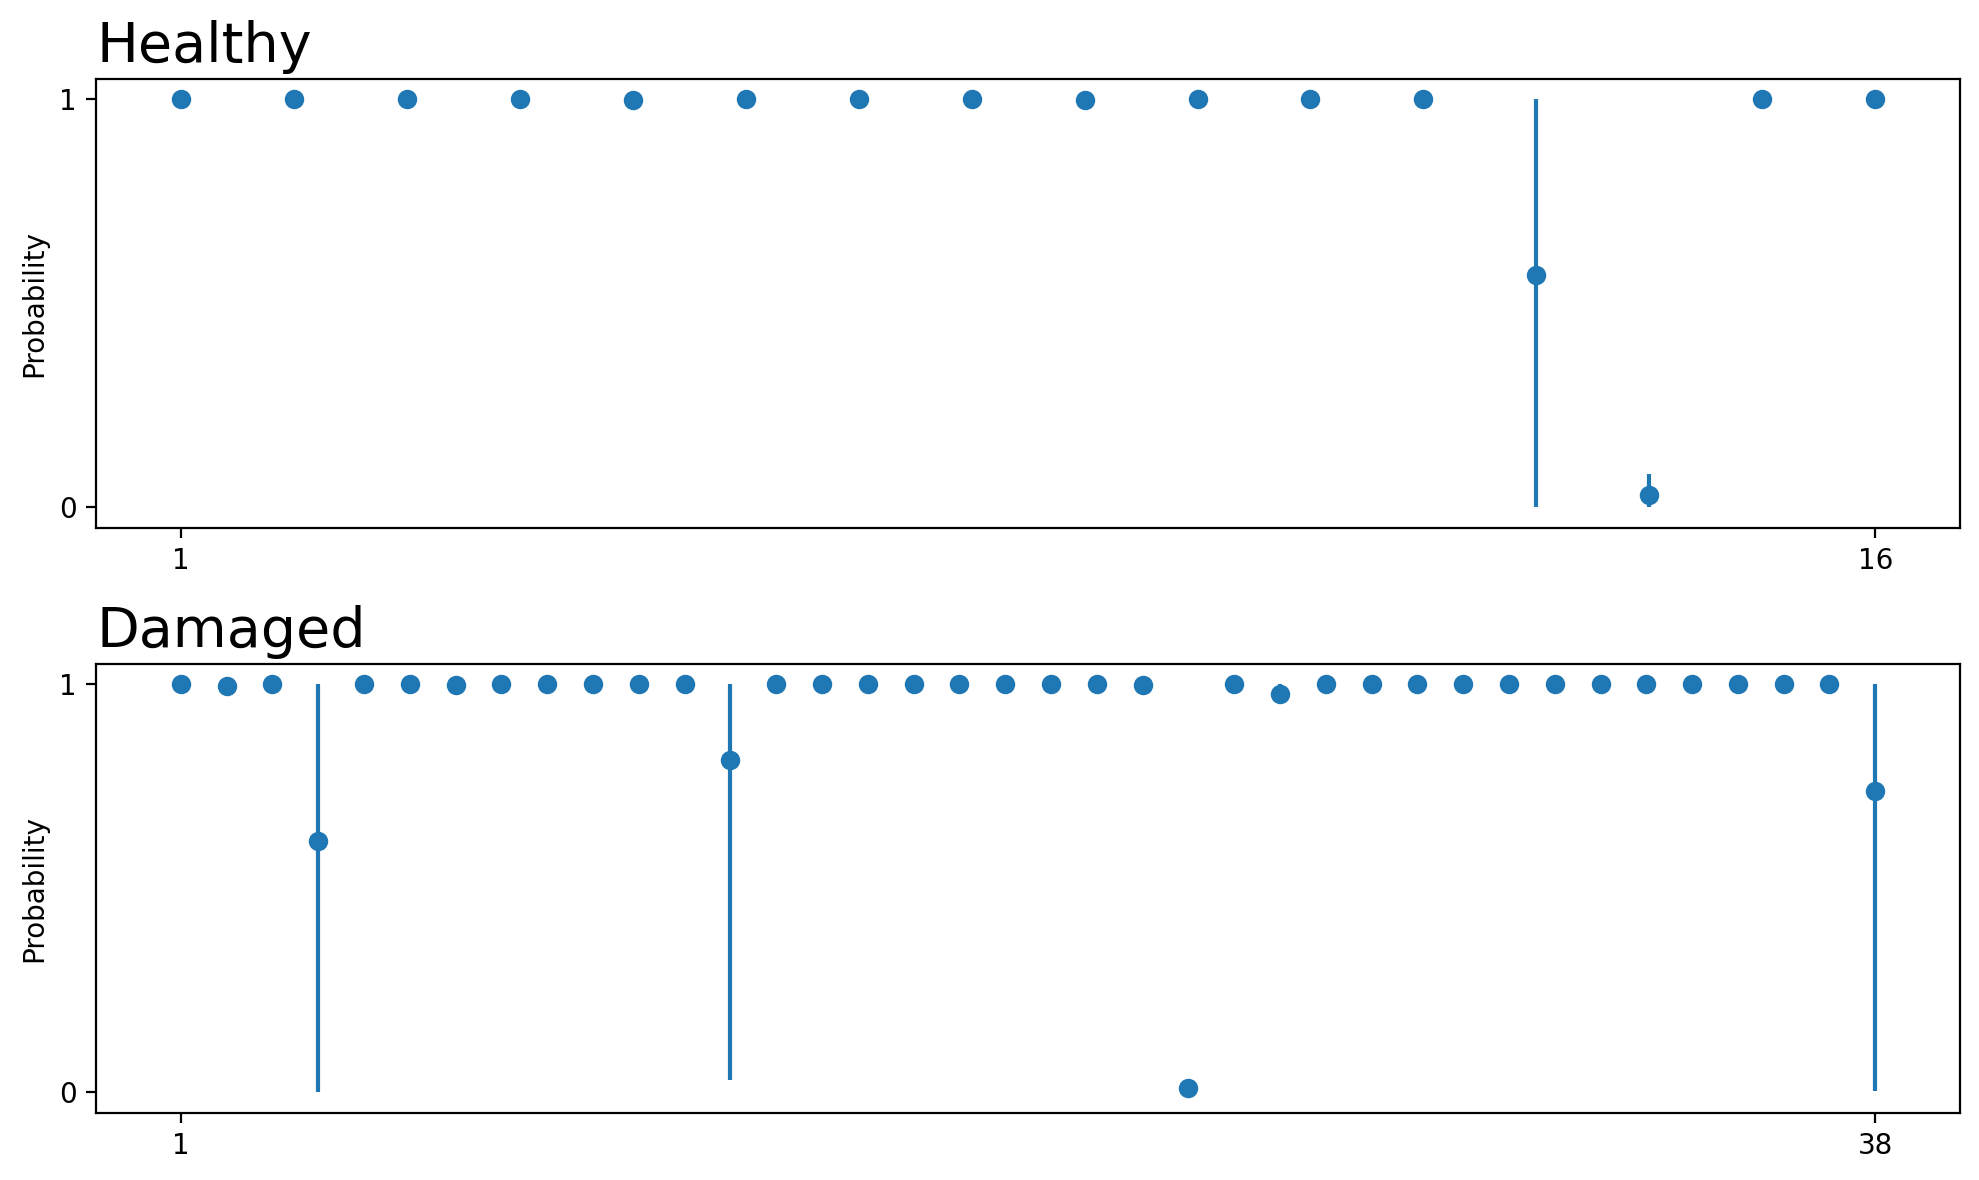

In [25]:
num_knots = 13
data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=6, 
                                                        num_knots=num_knots, mode = 'binary')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,mode='binary',plot=True)

### Diffrences between models
Three binary models for detecting drone propeller damage have been developed. The models differ primarily in terms of input data, which can be distinguished as follows:

    accelerometer with data aggregation in the time domain,
    gyroscope without data aggregation in the frequency domain,
    gyroscope with data aggregation in the frequency domain.

These models were developed due to the possibility of their direct application in unmanned aerial vehicles. The model using an accelerometer will require less computational power during integration, due to the limited number of operations performed. Meanwhile, the model based on a gyroscope must process input data after a Fourier transform, which increases computational complexity.

In [20]:
knots = [5,10,15,20,25]
frequencies = gyro_damaged['Frequencies']
num_iters = 100
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list = prepare_data(acc, frequencies=None, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary'))
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('results/agg_results.csv')

model = CmdStanModel(stan_file='stan/mix.stan')

# gyroscope without data aggregation in the frequency domain
result_dict_gyro = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro,index=[0])
    pd_res.to_csv('results/gyro_results.csv')

# gyroscope with data aggregation in the frequency domain
result_dict_gyro_agg = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro_agg, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
    pd_res.to_csv('results/gyro_agg_results.csv')

09:45:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

KeyboardInterrupt: 

In [ ]:
result_dict_gyro_agg

NameError: name 'result_dict_gyro_agg' is not defined